In [1]:
!pip install biopython --upgrade
!pip install pybloom_live
!pip install mmh3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 82.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.3/278.3 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.4 MB/s eta 0:00:00
  Created wheel for pybloom_live: filename=pybloom_live-4.0.0-py3-none-any.whl size=9228 sha256=2abd49479cce44e3be3a6ac2391ed727f9d6b74bc1f6ce3fd94da81ad348e9f3
  Stored in directory: /root/.cache/pip/wheels/36/8a/9f/83ab00e9a9b2b10cec6135fa2a6cd92a22edf3d87fdaae481e
Successfully built pybloom_live
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.2/93.2 kB 9.5 MB/s eta 0:00:00


In [2]:
import requests
import zipfile
import os
from io import BytesIO
from Bio import SeqIO
from pybloom_live import BloomFilter
import mmh3
import numpy as np
from hashlib import sha256
import hashlib
from collections import defaultdict
import random
import matplotlib.pyplot as plt
import time
import sys

In [3]:
# List of dataset URLs
urls = [
    "https://api.ncbi.nlm.nih.gov/datasets/v2/genome/accession/GCF_032191515.1/download?include_annotation_type=GENOME_FASTA&include_annotation_type=GENOME_GFF&include_annotation_type=RNA_FASTA&include_annotation_type=CDS_FASTA&include_annotation_type=PROT_FASTA&include_annotation_type=SEQUENCE_REPORT&hydrated=FULLY_HYDRATED"]

# Create a directory to save extracted data if it doesn't exist
base_dir = "genome_datasets"
os.makedirs(base_dir, exist_ok=True)

# Loop through all URLs and download, extract, and process each dataset
for i, url in enumerate(urls):
    print(f"Processing dataset {i+1}...")

    # Download the ZIP file
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        zip_file_name = f"dataset_{i+1}.zip"

        # Save the ZIP file locally
        with open(zip_file_name, 'wb') as zip_file:
            for chunk in response.iter_content(chunk_size=8192):
                zip_file.write(chunk)

        # Extract the ZIP file
        with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
            extract_path = os.path.join(base_dir, f"dataset_{i+1}")
            zip_ref.extractall(extract_path)

        # Clean up ZIP file to save space
        os.remove(zip_file_name)

        # Read relevant FASTA files from the extracted directory
        for root, dirs, files in os.walk(extract_path):
            for file in files:
                if file.endswith(".fna") or file.endswith(".faa"):  # Assuming these are the FASTA files
                    file_path = os.path.join(root, file)
                    print(f"Reading FASTA file: {file_path}")
                    with open(file_path, "r") as fasta_handle:
                        for seq_record in SeqIO.parse(fasta_handle, "fasta"):
                            # Print some details of the sequence, truncated for readability
                            print(f"ID: {seq_record.id}")
                            print(f"Description: {seq_record.description}")
                            print(f"Sequence: {seq_record.seq[:10]}...")  # Print first 100 bases/amino acids

    else:
        print(f"Failed to download dataset {i+1}. Status code: {response.status_code}")

print("All datasets processed successfully.")


Streaming output truncated to the last 5000 lines.
Sequence: ATGACCATGG...
ID: lcl|NC_091431.1_cds_XP_069736495.1_32185
Description: lcl|NC_091431.1_cds_XP_069736495.1_32185 [gene=ZNF532] [db_xref=GeneID:138733311] [protein=zinc finger protein 532 isoform X3] [protein_id=XP_069736495.1] [location=join(76416227..76418563,76423524..76423705,76431180..76431342,76434532..76434810,76438266..76438378,76440391..76440538,76441195..76441689)] [gbkey=CDS]
Sequence: ATGACCATGG...
ID: lcl|NC_091431.1_cds_XP_069736497.1_32186
Description: lcl|NC_091431.1_cds_XP_069736497.1_32186 [gene=ZNF532] [db_xref=GeneID:138733311] [protein=zinc finger protein 532 isoform X4] [protein_id=XP_069736497.1] [location=join(76416227..76418563,76434532..76434810,76438266..76438378,76440391..76440538,76441195..76441689)] [gbkey=CDS]
Sequence: ATGACCATGG...
ID: lcl|NC_091431.1_cds_XP_069736503.1_32187
Description: lcl|NC_091431.1_cds_XP_069736503.1_32187 [gene=SEC11C] [db_xref=GeneID:138733316] [protein=signal peptidase

In [18]:

class TraditionalBloomFilter:
    def __init__(self, capacity, error_rate=0.01):
        self.capacity = capacity
        self.error_rate = error_rate
        self.bloom = BloomFilter(capacity, error_rate)

    def add(self, item):
        self.bloom.add(item)

    def query(self, item):
        """Check if the item is likely in the filter."""
        return item in self.bloom

    def __contains__(self, item):
        return item in self.bloom

    def reset(self):
        """Reset the filter by reinitializing it."""
        self.__init__(self.capacity, self.error_rate)

    def get_memory_usage(self):
        """Estimate memory usage of the Bloom filter."""
        return sys.getsizeof(self.bloom)


class CuckooFilter:
    def __init__(self, capacity, bucket_size=2, max_relocations=500):
        self.capacity = capacity
        self.bucket_size = bucket_size
        self.max_relocations = max_relocations
        self.buckets = [[] for _ in range(capacity)]
        self.size = 0

    def add(self, item):
        index = self._hash(item)
        for bucket in self.buckets[index % self.capacity]:
            if item == bucket:
                return True  # Item already exists

        if len(self.buckets[index % self.capacity]) < self.bucket_size:
            self.buckets[index % self.capacity].append(item)
            self.size += 1
            return True

        return self._relocate_item(item, index)

    def query(self, item):
        """Check if the item is likely in the filter."""
        index = self._hash(item)
        return item in self.buckets[index % self.capacity]

    def __contains__(self, item):
        return self.query(item)

    def _hash(self, item, seed=0):
        return mmh3.hash(item, seed) % self.capacity

    def _relocate_item(self, item, index):
        current = item
        for _ in range(self.max_relocations):
            bucket_index = self._hash(current)
            bucket = self.buckets[bucket_index % self.capacity]
            if len(bucket) < self.bucket_size:
                bucket.append(current)
                return True
            else:
                # Swap items and try relocating the one in hand
                rand_index = random.randint(0, self.bucket_size - 1)
                current, bucket[rand_index] = bucket[rand_index], current
        return False  # Failed to place item

    def reset(self):
        """Reset the filter by reinitializing it."""
        self.__init__(self.capacity, self.bucket_size, self.max_relocations)

    def get_memory_usage(self):
        """Estimate memory usage of the Cuckoo filter."""
        return sys.getsizeof(self.buckets) + sum(sys.getsizeof(bucket) for bucket in self.buckets)


class RAMBOBloomFilter:
    def __init__(self, capacity, levels=3):
        self.capacity = capacity
        self.levels = levels
        self.filters = [TraditionalBloomFilter(capacity // levels) for _ in range(levels)]
        self.item_count = 0

    def add(self, item):
        if self.item_count >= self.capacity:
            raise IndexError("RAMBOBloomFilter is at capacity")
        level = self._select_level(item)
        self.filters[level].add(item)
        self.item_count += 1

    def query(self, item):
        """Check if the item is likely in the filter."""
        level = self._select_level(item)
        return item in self.filters[level]

    def __contains__(self, item):
        return self.query(item)

    def _select_level(self, item):
        # Determine which level of RAMBO to place the item
        return mmh3.hash(item) % self.levels

    def reset(self):
        """Reset the filter by reinitializing it."""
        self.__init__(self.capacity, self.levels)

    def get_memory_usage(self):
        """Estimate memory usage of the RAMBO filter."""
        return sum(filter_instance.get_memory_usage() for filter_instance in self.filters)


In [5]:
def perform_membership_testing(filters, sequences, k, test_sizes):
    """Perform membership testing and dynamically collect metrics."""
    num_queries = []
    fpr_values = {filter_name: [] for filter_name in filters.keys()}
    memory_values = {filter_name: [] for filter_name in filters.keys()}

    for test_size in test_sizes:
        subset_sequences = sequences[:test_size]
        test_kmers = [seq[i:i + k] for seq in subset_sequences for i in range(len(seq) - k + 1)]
        false_kmers = ["".join(random.choices("ATCG", k=k)) for _ in range(len(test_kmers))]

        num_queries.append(len(test_kmers))
        for filter_name, filter_instance in filters.items():
            filter_instance.reset()  # Reset the filter for fresh testing

            # Add true k-mers to the filter
            for kmer in test_kmers:
                filter_instance.add(kmer)

            # Calculate FPR
            false_positives = sum(1 for kmer in false_kmers if kmer in filter_instance)
            fpr = false_positives / len(false_kmers)
            fpr_values[filter_name].append(fpr)

            # Measure memory usage
            memory_usage = sys.getsizeof(filter_instance) + sum(sys.getsizeof(attr) for attr in filter_instance.__dict__.values())
            memory_values[filter_name].append(memory_usage / 1024)  # Convert to KB

    return num_queries, fpr_values, memory_values


In [6]:
def plot_metrics(num_queries, fpr_values, memory_values):
    """Generate separate plots for FPR and memory usage."""
    # Plot FPR
    plt.figure(figsize=(10, 6))
    for filter_name, fpr in fpr_values.items():
        plt.plot(num_queries, fpr, label=f'{filter_name} Filter', marker='o', linestyle='-')
    plt.title('False Positive Rate vs Number of Queries', fontsize=16)
    plt.xlabel('Number of Queries', fontsize=14)
    plt.ylabel('False Positive Rate (FPR)', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

    # Plot Memory Usage
    plt.figure(figsize=(10, 6))
    for filter_name, memory in memory_values.items():
        plt.plot(num_queries, memory, label=f'{filter_name} Filter', marker='s', linestyle='--')
    plt.title('Memory Usage vs Number of Queries', fontsize=16)
    plt.xlabel('Number of Queries', fontsize=14)
    plt.ylabel('Memory Usage (KB)', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()


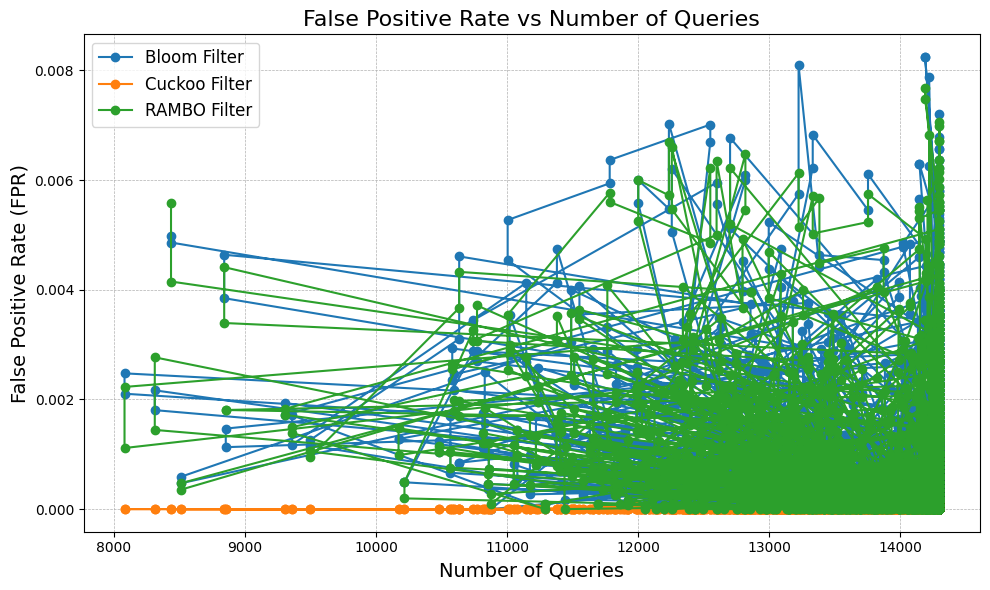

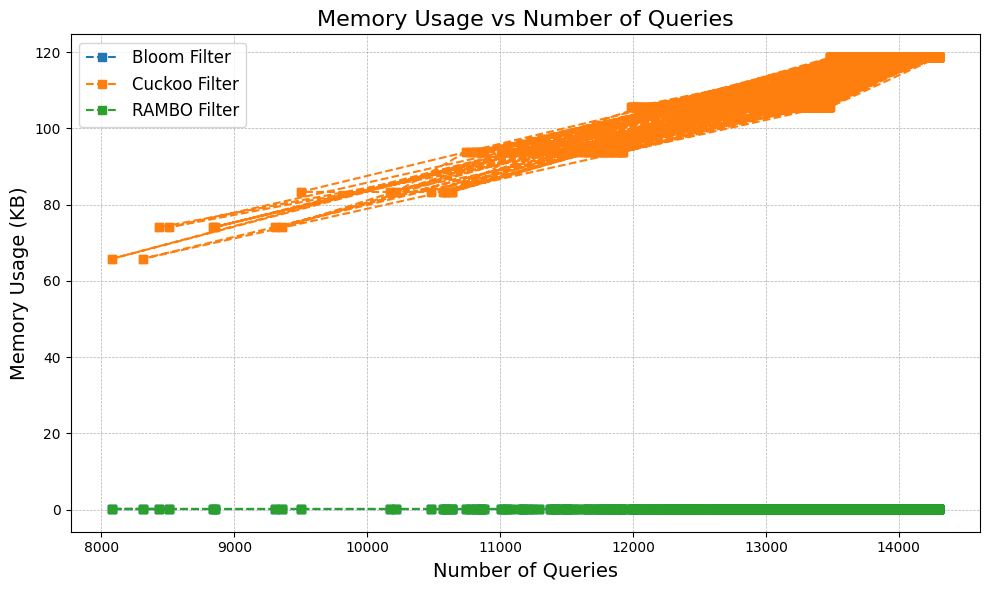

In [7]:
def main():
    # Extract sequences from your datasets in manageable batches
    base_dir = "genome_datasets"
    k = 15
    test_sizes = [100, 250]  # Reduced subset sizes for testing
    max_sequences_per_batch = 50  # Reduce the number of sequences per batch
    max_sequence_length = 300  # Truncate sequences to reduce k-mers

    # Initialize accumulators for results
    all_num_queries = []
    all_fpr_values = {"Bloom": [], "Cuckoo": [], "RAMBO": []}
    all_memory_values = {"Bloom": [], "Cuckoo": [], "RAMBO": []}

    for dataset_dir in os.listdir(base_dir):
        dataset_path = os.path.join(base_dir, dataset_dir)
        for root, dirs, files in os.walk(dataset_path):
            for file in files:
                if file.endswith(".fna") or file.endswith(".faa"):
                    file_path = os.path.join(root, file)

                    # Read sequences in batches
                    with open(file_path, "r") as fasta_handle:
                        sequences = []
                        for seq_record in SeqIO.parse(fasta_handle, "fasta"):
                            sequences.append(str(seq_record.seq[:max_sequence_length]))  # Truncate sequence
                            if len(sequences) >= max_sequences_per_batch:
                                # Process current batch
                                process_batch(sequences, k, test_sizes, all_num_queries, all_fpr_values, all_memory_values)
                                sequences = []  # Reset for next batch

                        # Process remaining sequences in the last batch
                        if sequences:
                            process_batch(sequences, k, test_sizes, all_num_queries, all_fpr_values, all_memory_values)

    # Plot metrics after processing all batches
    plot_metrics(all_num_queries, all_fpr_values, all_memory_values)


def process_batch(sequences, k, test_sizes, all_num_queries, all_fpr_values, all_memory_values):
    """Process a batch of sequences and collect metrics."""
    # Calculate filter capacity based on the batch size
    capacity = len(sequences) * (300 - k + 1)  # Adjust for truncated sequences
    # Calculate the total number of k-mers in all sequences
    total_kmers = sum(len(seq) - k + 1 for seq in sequences)

    # Initialize filters for the current batch using total_kmers as capacity
    filters = {
        "Bloom": TraditionalBloomFilter(capacity=total_kmers),
        "Cuckoo": CuckooFilter(capacity=total_kmers, bucket_size=2, max_relocations=500),
        "RAMBO": RAMBOBloomFilter(capacity=total_kmers, levels=3)
    }

    # Perform membership testing for the current batch
    num_queries, fpr_values, memory_values = perform_membership_testing(filters, sequences, k, test_sizes)

    # Accumulate results
    all_num_queries.extend(num_queries)
    for filter_name in filters.keys():
        all_fpr_values[filter_name].extend(fpr_values[filter_name])
        all_memory_values[filter_name].extend(memory_values[filter_name])


if __name__ == "__main__":
    main()


In [7]:

def plot_metrics(all_num_queries, all_fpr_values, all_memory_values):
    """Plot metrics with improved clarity."""
    filters = ["Bloom", "Cuckoo", "RAMBO"]

    # Aggregate data for better visualization
    num_queries = np.unique(all_num_queries)  # Use unique query counts for clarity
    avg_fpr = {filter_name: np.mean(all_fpr_values[filter_name]) for filter_name in filters}
    avg_memory = {filter_name: np.mean(all_memory_values[filter_name]) for filter_name in filters}

    # Create subplots for FPR and memory usage
    fig, axs = plt.subplots(2, 1, figsize=(10, 8))

    # Plot FPR values
    for filter_name in filters:
        axs[0].plot(
            num_queries,
            [avg_fpr[filter_name]] * len(num_queries),  # Simplify by showing average FPR
            label=f"{filter_name} Filter",
            marker='o'
        )
    axs[0].set_title("False Positive Rate (FPR)")
    axs[0].set_xlabel("Number of Queries")
    axs[0].set_ylabel("Average FPR")
    axs[0].legend()
    axs[0].grid(True)

    # Plot memory usage
    for filter_name in filters:
        axs[1].plot(
            num_queries,
            [avg_memory[filter_name]] * len(num_queries),  # Simplify by showing average memory usage
            label=f"{filter_name} Filter",
            marker='x'
        )
    axs[1].set_title("Memory Usage")
    axs[1].set_xlabel("Number of Queries")
    axs[1].set_ylabel("Memory Usage (Bytes)")
    axs[1].legend()
    axs[1].grid(True)

    # Adjust layout for clarity
    plt.tight_layout()
    plt.show()


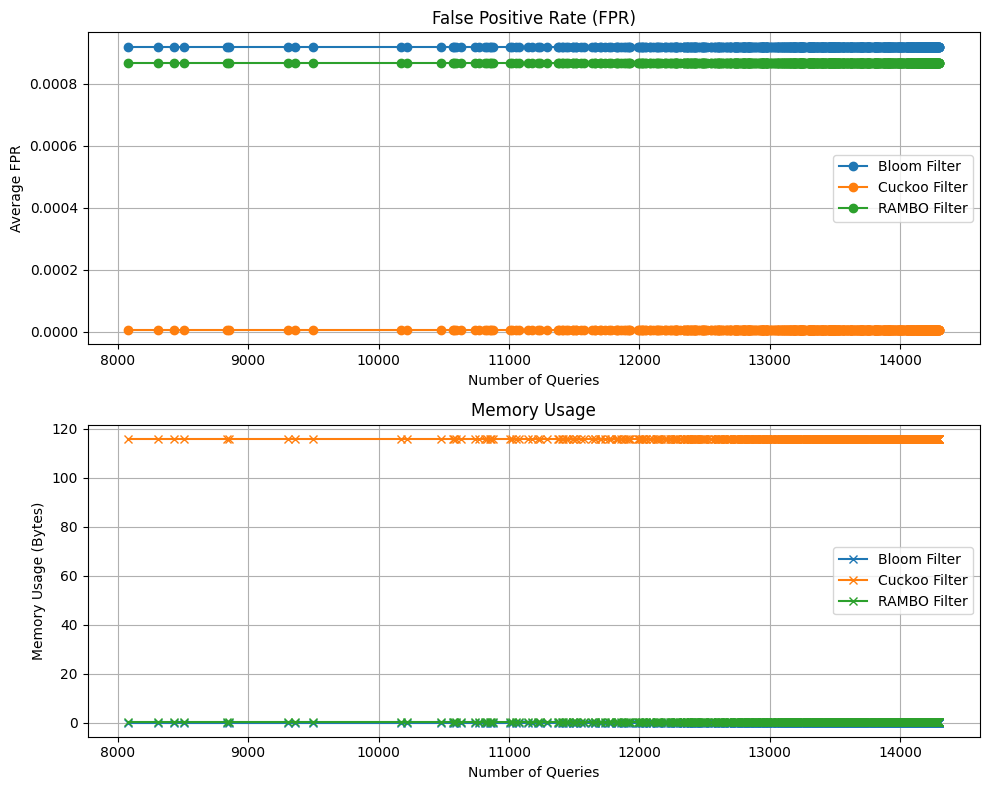

In [8]:
def main():
    # Extract sequences from your datasets in manageable batches
    base_dir = "genome_datasets"
    k = 15
    test_sizes = [100, 250]  # Reduced subset sizes for testing
    max_sequences_per_batch = 50  # Reduce the number of sequences per batch
    max_sequence_length = 300  # Truncate sequences to reduce k-mers

    # Initialize accumulators for results
    all_num_queries = []
    all_fpr_values = {"Bloom": [], "Cuckoo": [], "RAMBO": []}
    all_memory_values = {"Bloom": [], "Cuckoo": [], "RAMBO": []}

    for dataset_dir in os.listdir(base_dir):
        dataset_path = os.path.join(base_dir, dataset_dir)
        for root, dirs, files in os.walk(dataset_path):
            for file in files:
                if file.endswith(".fna") or file.endswith(".faa"):
                    file_path = os.path.join(root, file)

                    # Read sequences in batches
                    with open(file_path, "r") as fasta_handle:
                        sequences = []
                        for seq_record in SeqIO.parse(fasta_handle, "fasta"):
                            sequences.append(str(seq_record.seq[:max_sequence_length]))  # Truncate sequence
                            if len(sequences) >= max_sequences_per_batch:
                                # Process current batch
                                process_batch(sequences, k, test_sizes, all_num_queries, all_fpr_values, all_memory_values)
                                sequences = []  # Reset for next batch

                        # Process remaining sequences in the last batch
                        if sequences:
                            process_batch(sequences, k, test_sizes, all_num_queries, all_fpr_values, all_memory_values)

    # Plot metrics after processing all batches
    plot_metrics(all_num_queries, all_fpr_values, all_memory_values)


def process_batch(sequences, k, test_sizes, all_num_queries, all_fpr_values, all_memory_values):
    """Process a batch of sequences and collect metrics."""
    # Calculate filter capacity based on the batch size
    capacity = len(sequences) * (300 - k + 1)  # Adjust for truncated sequences
    # Calculate the total number of k-mers in all sequences
    total_kmers = sum(len(seq) - k + 1 for seq in sequences)

    # Initialize filters for the current batch using total_kmers as capacity
    filters = {
        "Bloom": TraditionalBloomFilter(capacity=total_kmers),
        "Cuckoo": CuckooFilter(capacity=total_kmers, bucket_size=2, max_relocations=500),
        "RAMBO": RAMBOBloomFilter(capacity=total_kmers, levels=3)
    }

    # Perform membership testing for the current batch
    num_queries, fpr_values, memory_values = perform_membership_testing(filters, sequences, k, test_sizes)

    # Accumulate results
    all_num_queries.extend(num_queries)
    for filter_name in filters.keys():
        all_fpr_values[filter_name].extend(fpr_values[filter_name])
        all_memory_values[filter_name].extend(memory_values[filter_name])


if __name__ == "__main__":
    main()


In [29]:
def perform_membership_testing(filters, sequences, k, test_sizes):
    """Perform membership testing and collect metrics."""
    num_queries = []
    fpr_values = {filter_name: [] for filter_name in filters.keys()}
    memory_values = {filter_name: [] for filter_name in filters.keys()}
    query_times = {filter_name: [] for filter_name in filters.keys()}

    for size in test_sizes:
        # Generate test queries
        test_queries = [seq[:k] for seq in sequences[:size]]

        # Perform tests for each filter
        for filter_name, filter_instance in filters.items():
            start_time = time.time()  # Start timing
            false_positives = 0

            for query in test_queries:
                if filter_instance.query(query) and query not in sequences:
                    false_positives += 1

            end_time = time.time()  # End timing
            query_time = end_time - start_time

            # Record metrics
            num_queries.append(len(test_queries))
            fpr_values[filter_name].append(false_positives / len(test_queries))
            memory_values[filter_name].append(filter_instance.get_memory_usage())
            query_times[filter_name].append(query_time)

    return num_queries, fpr_values, memory_values, query_times

def process_batch(sequences, k, test_sizes, all_num_queries, all_fpr_values, all_memory_values, all_query_times):
    """Process a batch of sequences and collect metrics."""
    capacity = len(sequences) * (300 - k + 1)
    total_kmers = sum(len(seq) - k + 1 for seq in sequences)

    filters = {
        "Bloom": TraditionalBloomFilter(capacity=total_kmers),
        "Cuckoo": CuckooFilter(capacity=total_kmers, bucket_size=2, max_relocations=500),
        "RAMBO": RAMBOBloomFilter(capacity=total_kmers, levels=3)
    }

    num_queries, fpr_values, memory_values, query_times = perform_membership_testing(filters, sequences, k, test_sizes)

    all_num_queries.extend(num_queries)
    for filter_name in filters.keys():
        all_fpr_values[filter_name].extend(fpr_values[filter_name])
        all_memory_values[filter_name].extend(memory_values[filter_name])
        all_query_times[filter_name].extend(query_times[filter_name])



In [28]:
def plot_metrics(all_num_queries, all_fpr_values, all_memory_values, all_query_times):
    """Plot metrics with improved clarity, including query time."""
    filters = ["Bloom", "Cuckoo", "RAMBO"]

    # Aggregate data for better visualization
    num_queries = np.unique(all_num_queries)  # Use unique query counts for clarity
    avg_fpr = {filter_name: np.mean(all_fpr_values[filter_name]) for filter_name in filters}
    avg_memory = {filter_name: np.mean(all_memory_values[filter_name]) for filter_name in filters}
    avg_query_time = {filter_name: np.mean(all_query_times[filter_name]) for filter_name in filters}

    # Create subplots for FPR, memory usage, and query time
    fig, axs = plt.subplots(3, 1, figsize=(10, 12))

    # Plot FPR values
    for filter_name in filters:
        axs[0].plot(
            num_queries,
            [avg_fpr[filter_name]] * len(num_queries),  # Simplify by showing average FPR
            label=f"{filter_name} Filter",
            marker='o'
        )
    axs[0].set_title("False Positive Rate (FPR)")
    axs[0].set_xlabel("Number of Queries")
    axs[0].set_ylabel("Average FPR")
    axs[0].legend()
    axs[0].grid(True)

    # Plot memory usage
    for filter_name in filters:
        axs[1].plot(
            num_queries,
            [avg_memory[filter_name]] * len(num_queries),  # Simplify by showing average memory usage
            label=f"{filter_name} Filter",
            marker='x'
        )
    axs[1].set_title("Memory Usage")
    axs[1].set_xlabel("Number of Queries")
    axs[1].set_ylabel("Memory Usage (Bytes)")
    axs[1].legend()
    axs[1].grid(True)

    # Plot query times
    for filter_name in filters:
        axs[2].plot(
            num_queries,
            [avg_query_time[filter_name]] * len(num_queries),  # Simplify by showing average query time
            label=f"{filter_name} Filter",
            marker='^'
        )
    axs[2].set_title("Query Time")
    axs[2].set_xlabel("Number of Queries")
    axs[2].set_ylabel("Query Time (Seconds)")
    axs[2].legend()
    axs[2].grid(True)

    # Adjust layout for clarity
    plt.tight_layout()
    plt.show()


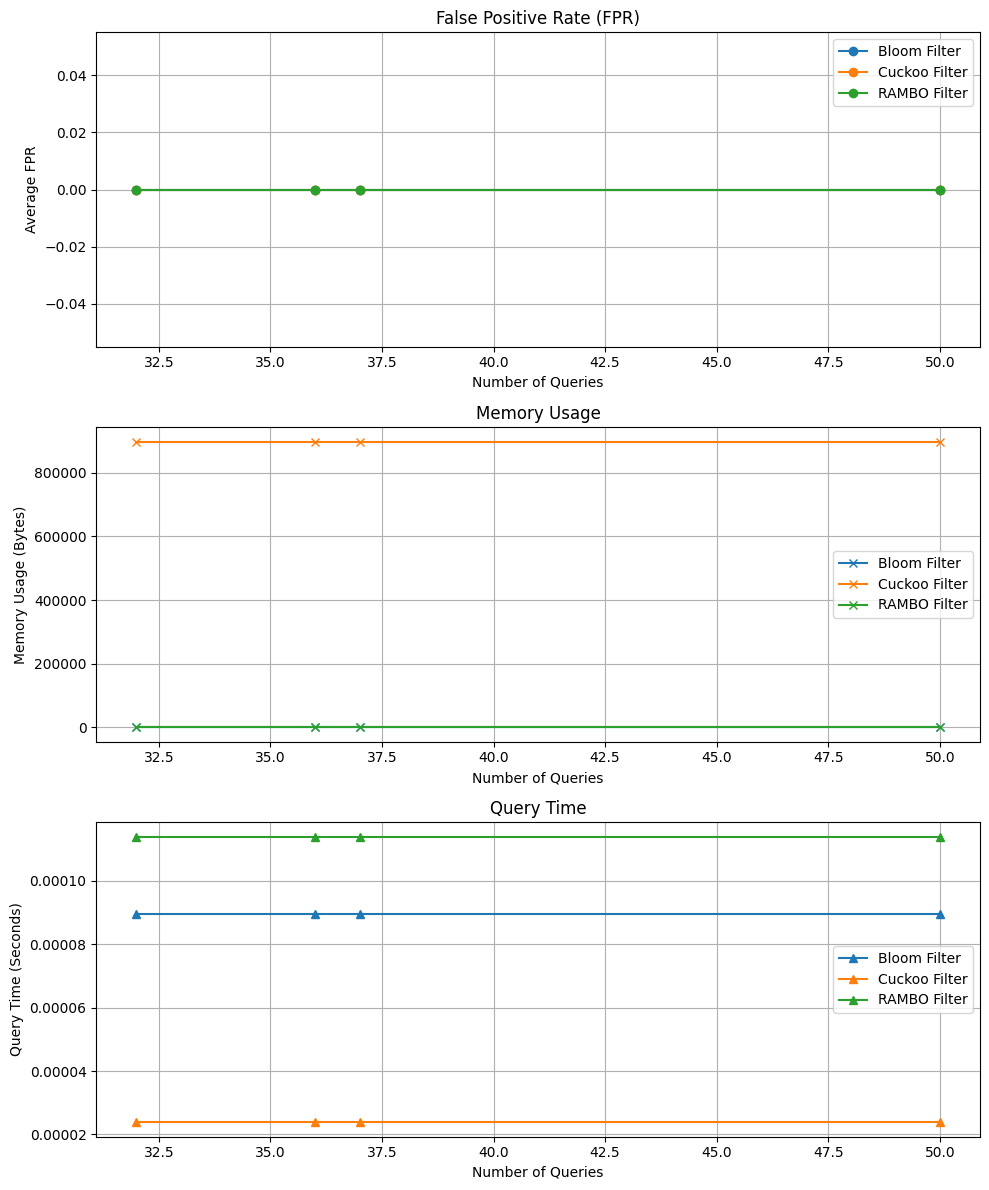

In [33]:
def main():
    # Extract sequences from your datasets in manageable batches
    base_dir = "genome_datasets"
    k = 15
    test_sizes = [100, 250]  # Reduced subset sizes for testing
    max_sequences_per_batch = 50  # Reduce the number of sequences per batch
    max_sequence_length = 300  # Truncate sequences to reduce k-mers

    # Initialize accumulators for results
    all_num_queries = []
    all_fpr_values = {"Bloom": [], "Cuckoo": [], "RAMBO": []}
    all_memory_values = {"Bloom": [], "Cuckoo": [], "RAMBO": []}
    all_query_times = {"Bloom": [], "Cuckoo": [], "RAMBO": []}  # Added query time accumulator

    for dataset_dir in os.listdir(base_dir):
        dataset_path = os.path.join(base_dir, dataset_dir)
        for root, dirs, files in os.walk(dataset_path):
            for file in files:
                if file.endswith(".fna") or file.endswith(".faa"):
                    file_path = os.path.join(root, file)

                    # Read sequences in batches
                    with open(file_path, "r") as fasta_handle:
                        sequences = []
                        for seq_record in SeqIO.parse(fasta_handle, "fasta"):
                            sequences.append(str(seq_record.seq[:max_sequence_length]))  # Truncate sequence
                            if len(sequences) >= max_sequences_per_batch:
                                # Process current batch
                                process_batch(
                                    sequences, k, test_sizes,
                                    all_num_queries, all_fpr_values,
                                    all_memory_values, all_query_times
                                )
                                sequences = []  # Reset for next batch

                        # Process remaining sequences in the last batch
                        if sequences:
                            process_batch(
                                sequences, k, test_sizes,
                                all_num_queries, all_fpr_values,
                                all_memory_values, all_query_times
                            )

    # Plot metrics after processing all batches
    plot_metrics(all_num_queries, all_fpr_values, all_memory_values, all_query_times)
if __name__ == "__main__":
    main()

In [31]:
def process_batch(sequences, k, test_sizes, all_num_queries, all_fpr_values, all_memory_values, all_query_times):
    """Process a batch of sequences and collect metrics."""
    # Calculate filter capacity based on the batch size
    capacity = len(sequences) * (300 - k + 1)  # Adjust for truncated sequences
    # Calculate the total number of k-mers in all sequences
    total_kmers = sum(len(seq) - k + 1 for seq in sequences)

    # Initialize filters for the current batch using total_kmers as capacity
    filters = {
        "Bloom": TraditionalBloomFilter(capacity=total_kmers),
        "Cuckoo": CuckooFilter(capacity=total_kmers, bucket_size=2, max_relocations=500),
        "RAMBO": RAMBOBloomFilter(capacity=total_kmers, levels=3)
    }

    # Perform membership testing for the current batch
    num_queries, fpr_values, memory_values, query_times = perform_membership_testing(filters, sequences, k, test_sizes)

    # Accumulate results
    all_num_queries.extend(num_queries)
    for filter_name in filters.keys():
        all_fpr_values[filter_name].extend(fpr_values[filter_name])
        all_memory_values[filter_name].extend(memory_values[filter_name])
        all_query_times[filter_name].extend(query_times[filter_name])  # Add query times


In [32]:
def perform_membership_testing(filters, sequences, k, test_sizes):
    """Perform membership testing and collect metrics."""
    num_queries = []
    fpr_values = {filter_name: [] for filter_name in filters.keys()}
    memory_values = {filter_name: [] for filter_name in filters.keys()}
    query_times = {filter_name: [] for filter_name in filters.keys()}

    for size in test_sizes:
        # Generate test queries
        test_queries = [seq[:k] for seq in sequences[:size]]

        # Perform tests for each filter
        for filter_name, filter_instance in filters.items():
            start_time = time.time()  # Start timing
            false_positives = 0

            for query in test_queries:
                if filter_instance.query(query) and query not in sequences:
                    false_positives += 1

            end_time = time.time()  # End timing
            query_time = end_time - start_time

            # Record metrics
            num_queries.append(len(test_queries))
            fpr_values[filter_name].append(false_positives / len(test_queries))
            memory_values[filter_name].append(filter_instance.get_memory_usage())
            query_times[filter_name].append(query_time)  # Add query time for this filter

    return num_queries, fpr_values, memory_values, query_times
